In [1]:
import pickle
import plot_utils as pu
import embedding_utils as eu
from sklearn.manifold import TSNE
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

/home/maximos/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = 'data/contrastive_dataset/CA_test.pickle'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

In [3]:
d = dataset[1]
print(d.keys())
print(type(d['lstm_embeddings']), d['lstm_embeddings'].shape)
print(type(d['matrix_embeddings']), d['matrix_embeddings'].shape)
print(type(d['bot_embeddings']), d['bot_embeddings'].shape)
print(type(d['graph_embeddings']), d['graph_embeddings'].shape)
print(type(d['transformer_embeddings']), d['transformer_embeddings'].shape)

dict_keys(['harmony_ids', 'pianoroll', 'lstm_embeddings', 'matrix', 'matrix_embeddings', 'bot', 'bot_embeddings', 'graph', 'graph_embeddings', 'transformer_embeddings'])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([512])


In [4]:
parent_dir_idioms = 'data/contrastive_dataset'
subdirs_dirs = os.listdir(parent_dir_idioms)
idiom_dirs = [f for f in subdirs_dirs if '.pickle' not in f or 'CA_train' not in f]

full_dirs = []
for d in tqdm(idiom_dirs):
    full_dirs.append(os.path.join(parent_dir_idioms, d))

100%|██████████| 33/33 [00:00<00:00, 781988.88it/s]


In [5]:
idiom_ids = []
lstm_embeds = []
matrix_embeds = []
bot_embeds = []
graph_embeds = []
transformer_embeds = []

for i, idiom in enumerate(full_dirs):
    print(idiom)
    with open(idiom, 'rb') as f:
        dataset = pickle.load(f)
    for d in dataset:
        lstm_embeds.append(d['lstm_embeddings'].numpy())
        matrix_embeds.append(d['matrix_embeddings'].numpy())
        bot_embeds.append(d['bot_embeddings'].numpy())
        graph_embeds.append(d['graph_embeddings'].numpy())
        transformer_embeds.append(d['transformer_embeddings'].numpy())
        idiom_ids.append( i )

data/contrastive_dataset/organum.pickle
data/contrastive_dataset/Kostka-Payne.pickle
data/contrastive_dataset/Jazz.pickle
data/contrastive_dataset/Whitacre.pickle
data/contrastive_dataset/Secundal.pickle
data/contrastive_dataset/GreekLabelet.pickle
data/contrastive_dataset/Hindemith.pickle
data/contrastive_dataset/DiatonicModalityPandiatonic.pickle
data/contrastive_dataset/Grieg.pickle
data/contrastive_dataset/WholeTone.pickle
data/contrastive_dataset/Mussorgsky.pickle
data/contrastive_dataset/Polychords.pickle
data/contrastive_dataset/Octatonic.pickle
data/contrastive_dataset/beatles.pickle
data/contrastive_dataset/CA_test.pickle
data/contrastive_dataset/epirusBassDrone.pickle
data/contrastive_dataset/Quartal.pickle
data/contrastive_dataset/fauxbourdon.pickle
data/contrastive_dataset/Rebetika.pickle
data/contrastive_dataset/BachChorales.pickle
data/contrastive_dataset/Impressionistic.pickle
data/contrastive_dataset/KostkaPayne.pickle
data/contrastive_dataset/epirus.pickle
data/contras

In [6]:
idiom_ids_np = np.vstack(idiom_ids)
lstm_embeds_np = np.vstack(lstm_embeds)
matrix_embeds_np = np.vstack(matrix_embeds)
bot_embeds_np = np.vstack(bot_embeds)
graph_embeds_np = np.vstack(graph_embeds)
transformer_embeds_np = np.vstack(transformer_embeds)

In [7]:
print(transformer_embeds_np.shape)

(1121, 512)


In [8]:
lstm_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(lstm_embeds_np)
matrix_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(matrix_embeds_np)
bot_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(bot_embeds_np)
graph_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(graph_embeds_np)
transformer_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(transformer_embeds_np)

In [9]:
def knn_results(idiom_embeds_np, ids_np):
    X = idiom_embeds_np
    y = ids_np.squeeze()

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=7)

    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    print("10-Fold CV Accuracy:")
    print(f"Mean accuracy: {np.mean(accuracies):.4f}")
    print(f"Std: {np.std(accuracies):.4f}")

    # report
    all_preds = []
    all_true = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    print(classification_report(all_true, all_preds))


In [10]:
print('LSTM results')
knn_results(lstm_embeds_np, idiom_ids_np)

LSTM results
10-Fold CV Accuracy:
Mean accuracy: 0.6896
Std: 0.0277
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.12      0.27      0.17        41
           2       0.32      0.37      0.34        27
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        10
           8       1.00      0.14      0.25         7
           9       0.20      0.75      0.32         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.50      0.14      0.22         7
          13       0.00      0.00      0.00        10
          14       0.80      0.95      0.87       756
          15       0.00      0.00      0.00         4
          16 

/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [11]:
print('Matrix results')
knn_results(matrix_embeds_np, idiom_ids_np)

Matrix results
10-Fold CV Accuracy:
Mean accuracy: 0.6477
Std: 0.0293
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.10      0.22      0.14        41
           2       0.32      0.48      0.38        27
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        10
           8       1.00      0.14      0.25         7
           9       0.12      0.25      0.17         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        10
          14       0.80      0.89      0.84       756
          15       0.00      0.00      0.00         4
          1

/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [12]:
print('BoT results')
knn_results(bot_embeds_np, idiom_ids_np)

BoT results
10-Fold CV Accuracy:
Mean accuracy: 0.6699
Std: 0.0233
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.12      0.20      0.15        41
           2       0.39      0.52      0.44        27
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        10
           8       0.50      0.29      0.36         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.75      0.43      0.55         7
          13       0.00      0.00      0.00        10
          14       0.88      0.87      0.87       756
          15       0.00      0.00      0.00         4
          16  

/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [13]:
print('Graph results')
knn_results(graph_embeds_np, idiom_ids_np)

Graph results
10-Fold CV Accuracy:
Mean accuracy: 0.7083
Std: 0.0216
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.02      0.02      0.02        41
           2       0.23      0.19      0.20        27
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.40      0.33      0.36         6
           7       0.00      0.00      0.00        10
           8       0.17      0.14      0.15         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        10
          14       0.79      0.98      0.87       756
          15       0.00      0.00      0.00         4
          16

/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [14]:
print('Transformer results')
knn_results(transformer_embeds_np, idiom_ids_np)

Transformer results
10-Fold CV Accuracy:
Mean accuracy: 0.7431
Std: 0.0165


/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/maximos/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.12      0.20      0.15        41
           2       0.50      0.41      0.45        27
           3       0.00      0.00      0.00         3
           4       0.40      0.50      0.44         4
           5       0.33      0.20      0.25         5
           6       0.00      0.00      0.00         6
           7       0.33      0.10      0.15        10
           8       0.43      0.43      0.43         7
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.17      0.14      0.15         7
          13       0.00      0.00      0.00        10
          14       0.86      0.96      0.91       756
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       0.00    

/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maximos/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


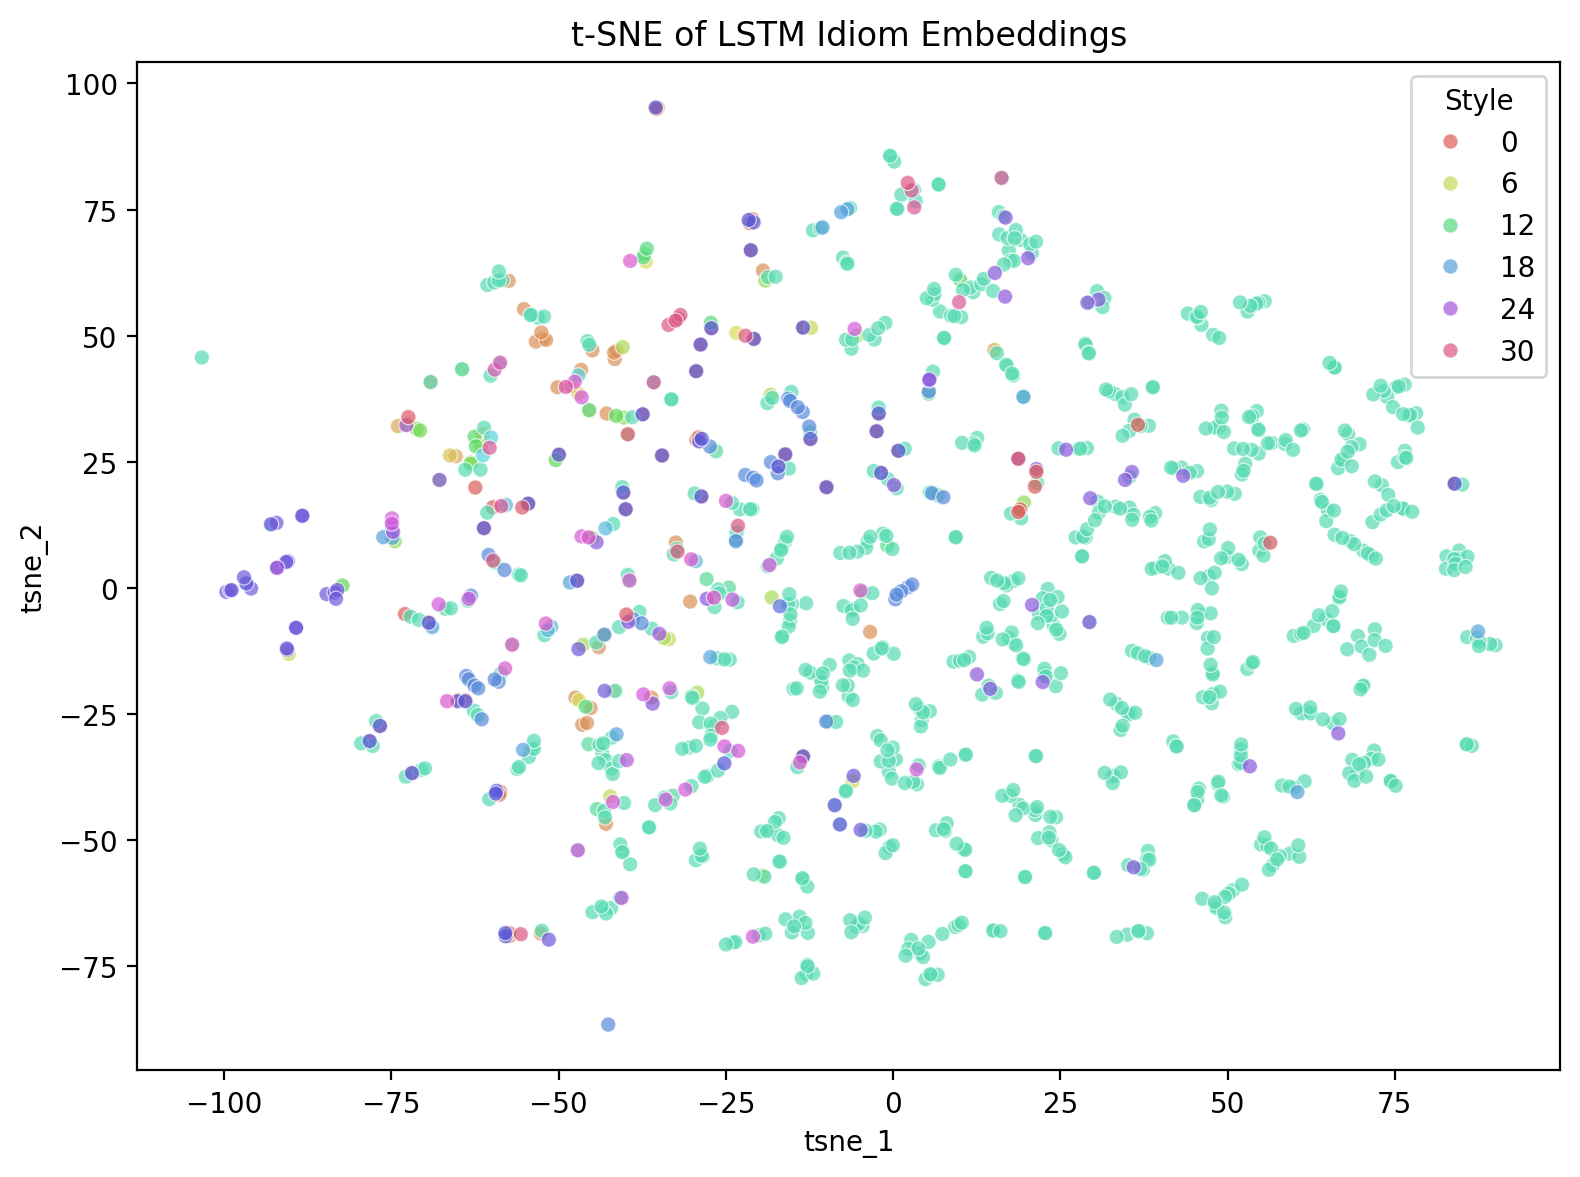

In [15]:
pu.plot_idioms_2(lstm_tsne, idiom_ids_np, 'LSTM')

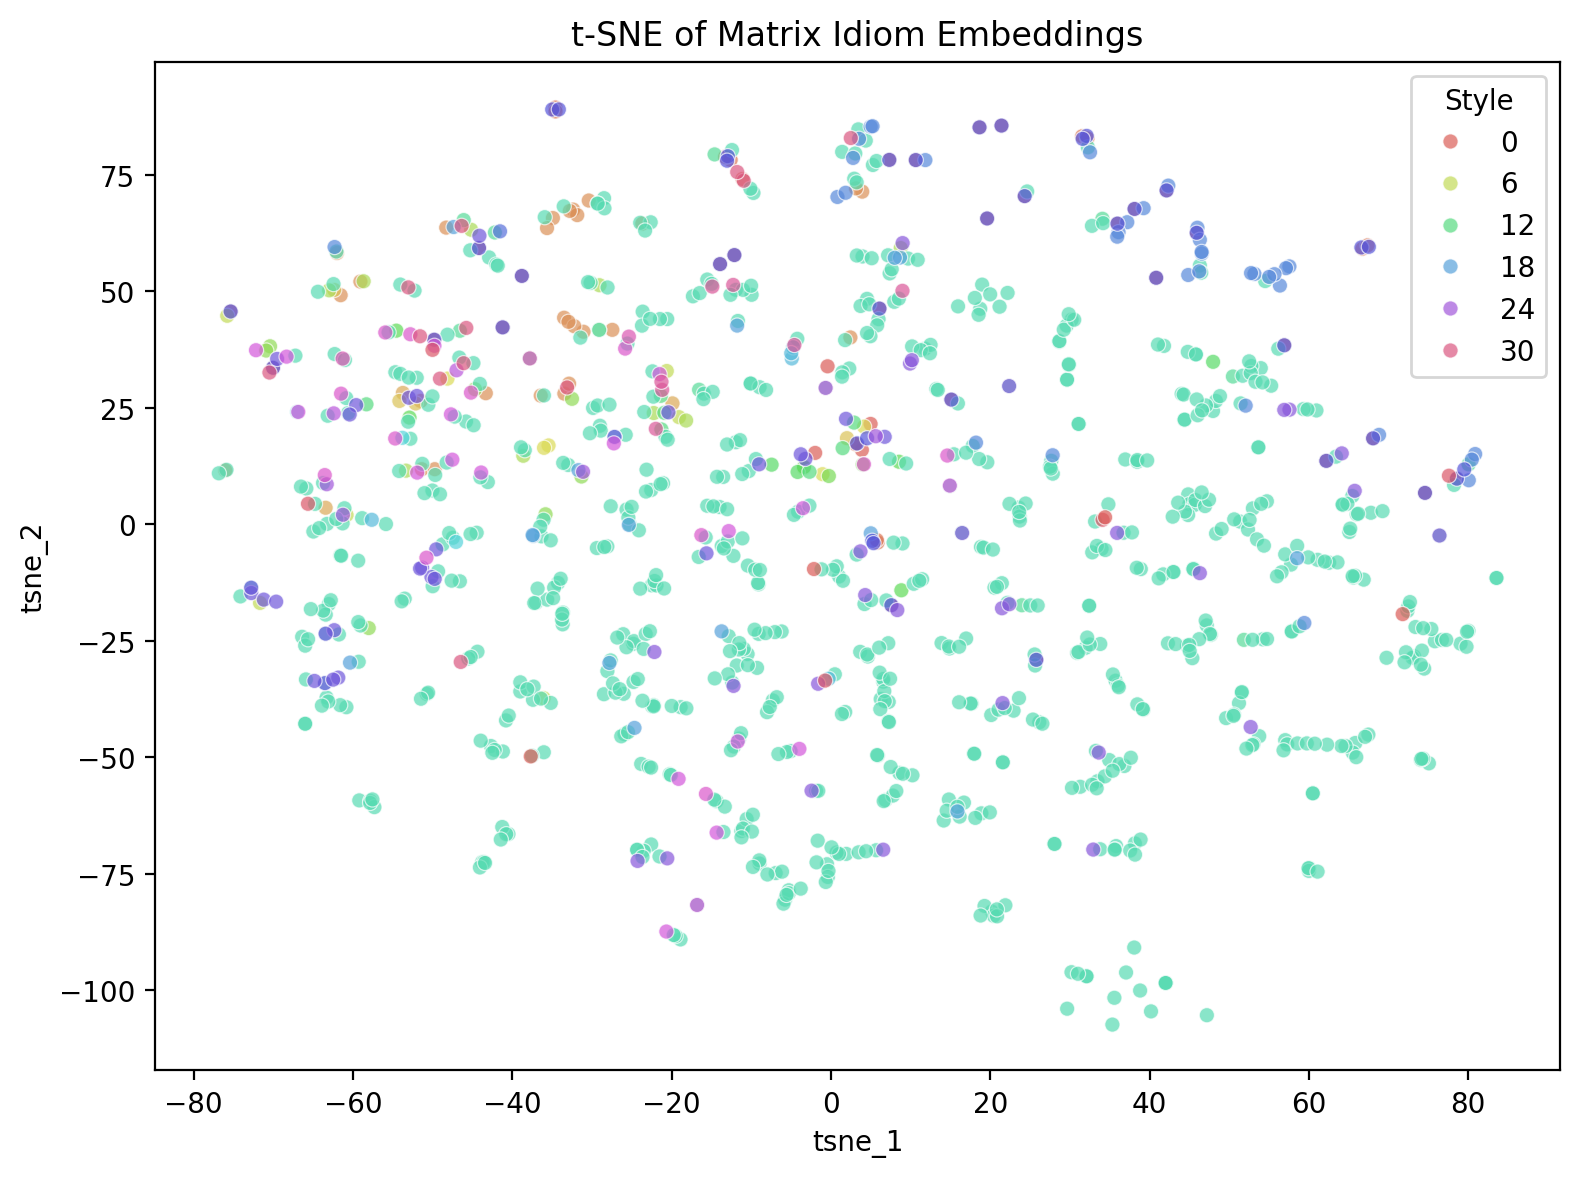

In [16]:
pu.plot_idioms_2(matrix_tsne, idiom_ids_np, 'Matrix')

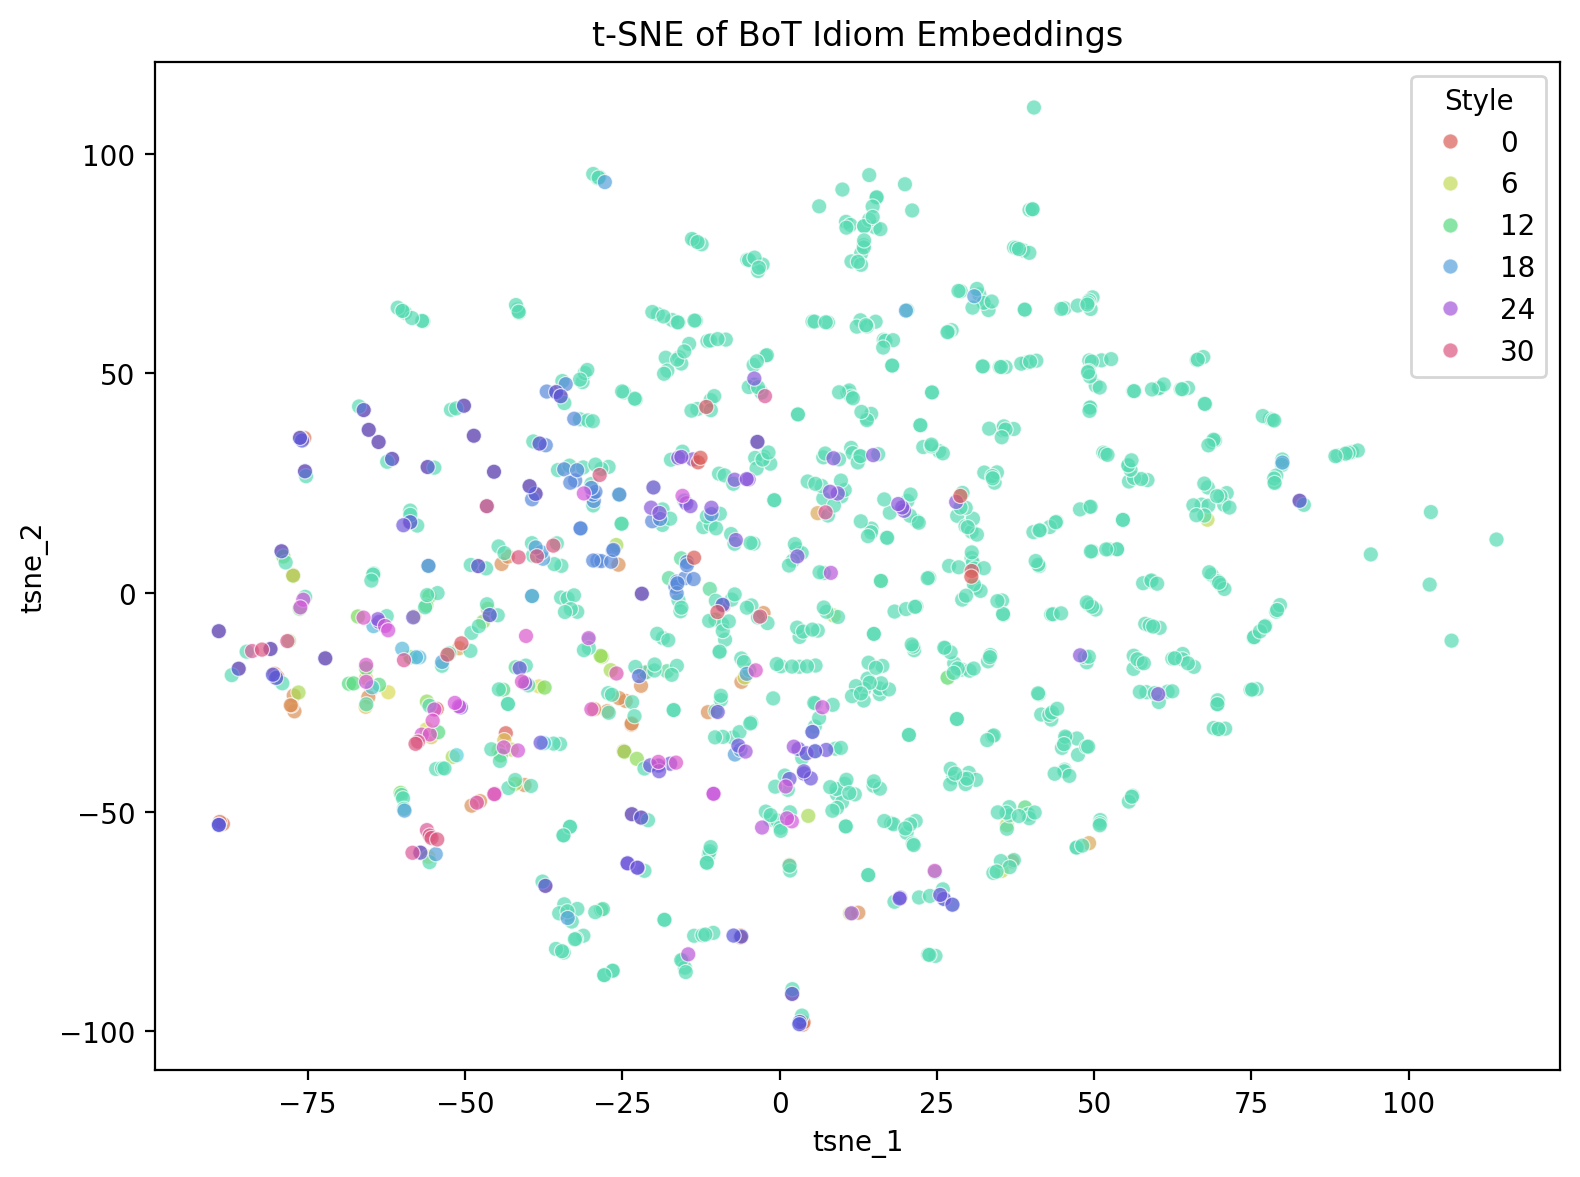

In [17]:
pu.plot_idioms_2(bot_tsne, idiom_ids_np, 'BoT')

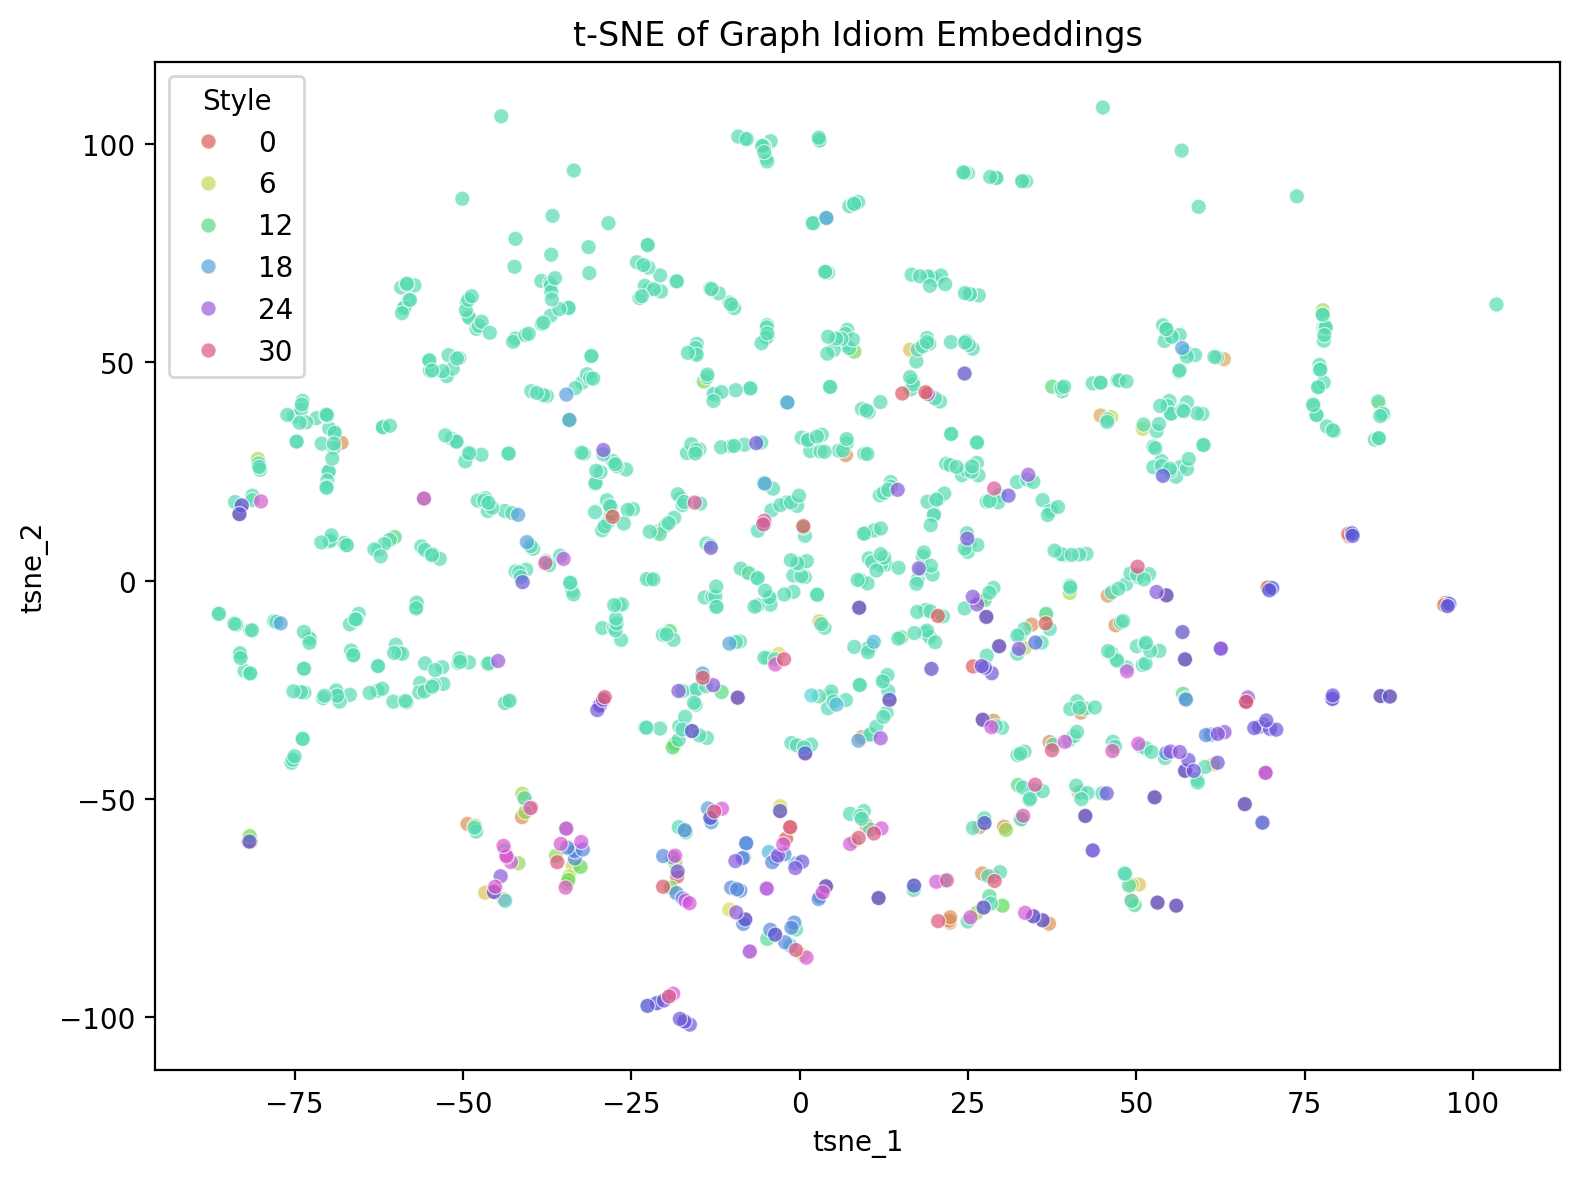

In [18]:
pu.plot_idioms_2(graph_tsne, idiom_ids_np, 'Graph')

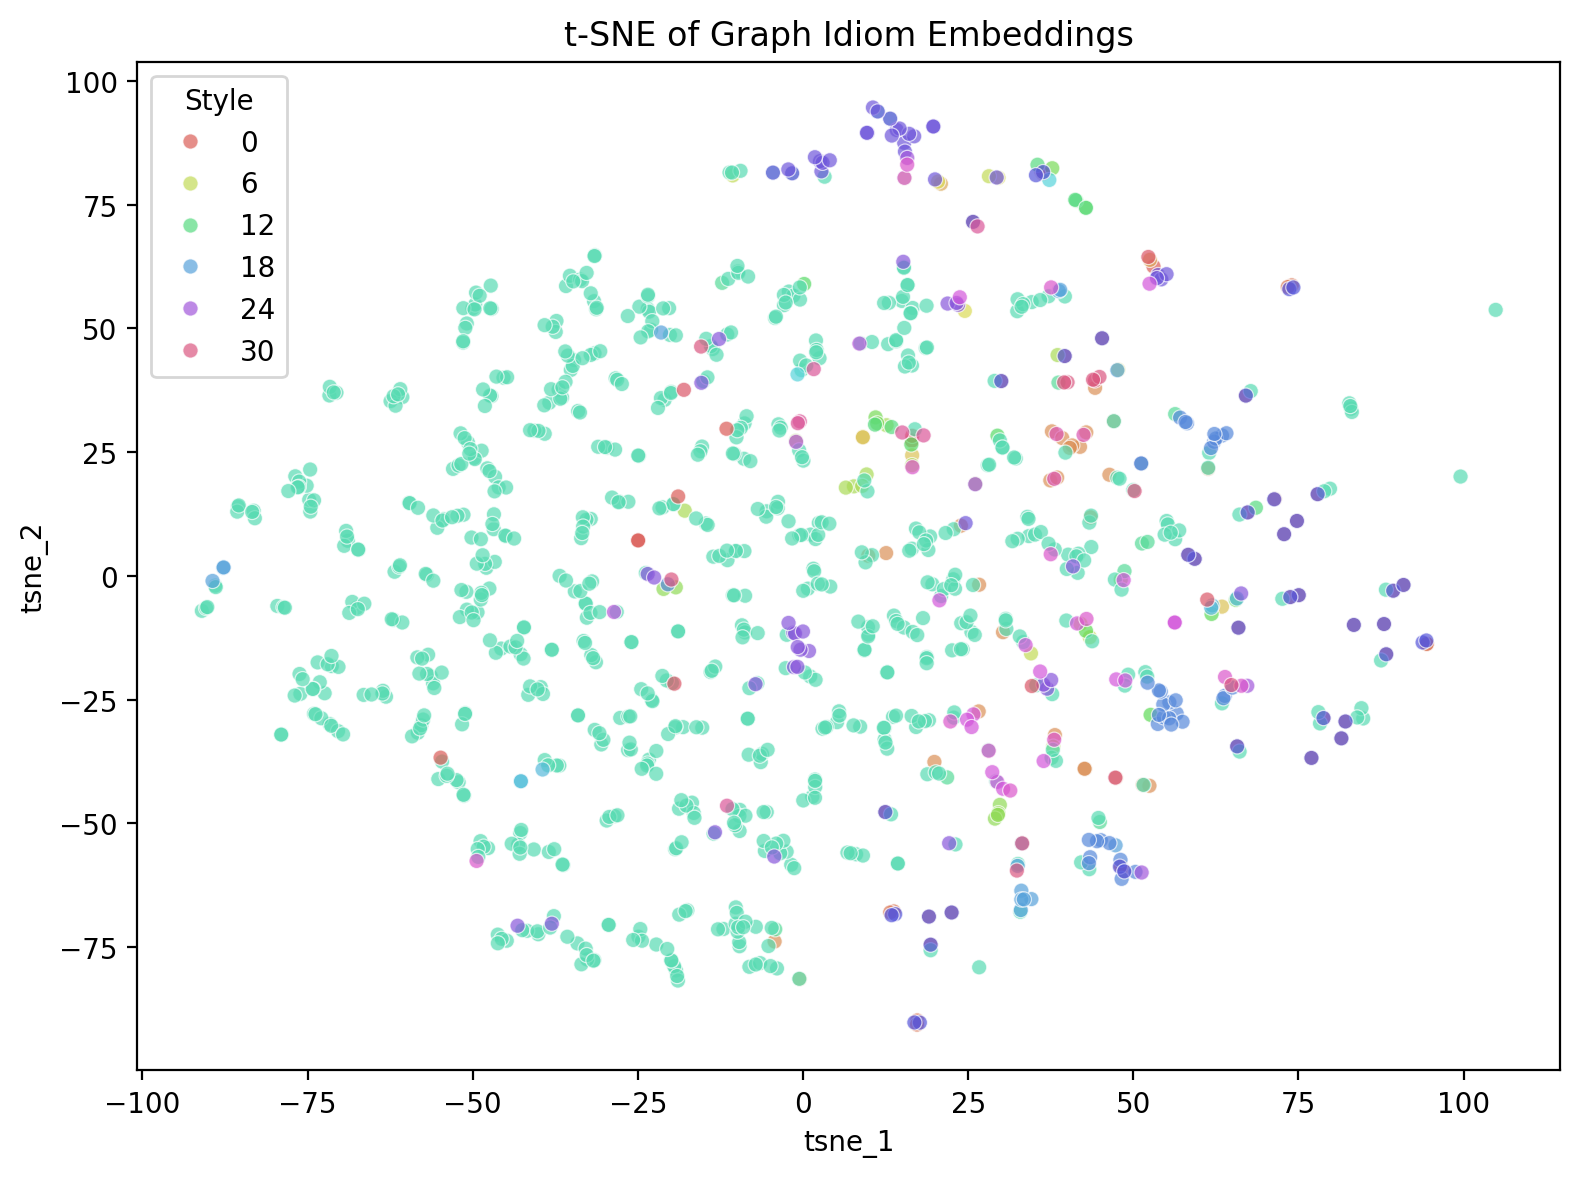

In [19]:
pu.plot_idioms_2(transformer_tsne, idiom_ids_np, 'Graph')